In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os,glob
import librosa
import librosa.display
import IPython
from IPython.display import Audio
from IPython.display import Image
import warnings; warnings.filterwarnings('ignore')

In [2]:
!pip install -U librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cp '/content/drive/MyDrive/RAVDESS.zip' .
!unzip -q RAVDESS.zip

In [5]:
sample_rate=48000
def feature_melspectrogram(
    waveform,
    sample_rate,
    fft = 1024,
    winlen = 512,
    window='hamming',
    hop=256,
    mels=128,
    ):

    # Produce the mel spectrogram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # Using 8khz as upper frequency bound should be enough for most speech classification tasks
    melspectrogram = librosa.feature.melspectrogram(
        y=waveform,
        sr=sample_rate,
        n_fft=fft,
        win_length=winlen,
        window=window,
        hop_length=hop,
        n_mels=mels,
        fmax=sample_rate/2)

    # convert from power (amplitude**2) to decibels
    # necessary for network to learn - doesn't converge with raw power spectrograms
    melspectrogram = librosa.power_to_db(melspectrogram, ref=np.max)

    return melspectrogram

def feature_mfcc(
    waveform,
    sample_rate,
    n_mfcc = 40,
    fft = 1024,
    winlen = 512,
    window='hamming',
    #hop=256, # increases # of time steps; was not helpful
    mels=128
    ):

    # Compute the MFCCs for all STFT frames
    # 40 mel filterbanks (n_mfcc) = 40 coefficients
    mfc_coefficients=librosa.feature.mfcc(
        y=waveform,
        sr=sample_rate,
        n_mfcc=n_mfcc,
        n_fft=fft,
        win_length=winlen,
        window=window,
        #hop_length=hop,
        n_mels=mels,
        fmax=sample_rate/2
        )

    return mfc_coefficients

def get_features(waveforms, features, samplerate):

    # initialize counter to track progress
    file_count = 0

    # process each waveform individually to get its MFCCs
    for waveform in waveforms:
        mfccs = feature_mfcc(waveform, sample_rate)
        features.append(mfccs)
        file_count += 1

        # print progress
        print('\r'+f' Processed {file_count}/{len(waveforms)} waveforms',end='')

    # return all features from list of waveforms
    return features

def get_waveforms(file):

    # load an individual sample audio file
    # read the full 3 seconds of the file, cut off the first 0.5s of silence; native sample rate = 48k
    # don't need to store the sample rate that librosa.load returns
    waveform, _ = librosa.load(file, duration=3, offset=0.5, sr=sample_rate)

    # make sure waveform vectors are homogenous by defining explicitly
    waveform_homo = np.zeros((int(sample_rate*3,)))
    waveform_homo[:len(waveform)] = waveform

    # return a single file's waveform
    return waveform_homo

# RAVDESS dataset emotions
# shift emotions left to be 0 indexed for PyTorch
emotions_dict ={
    '0':'surprised',
    '1':'neutral',
    '2':'calm',
    '3':'happy',
    '4':'sad',
    '5':'angry',
    '6':'fearful',
    '7':'disgust'
}

# Additional attributes from RAVDESS to play with
emotion_attributes = {
    '01': 'normal',
    '02': 'strong'
}


In [6]:

data_path='./Actor_*/*.wav'
def load_data():
  print('hlo')
  emotions=[]
  waveforms=[]
  intensities,genders=[],[]
  file_count=0
  for file in glob.glob(data_path):
    file_name=os.path.basename(file)
    emotion=int(file_name.split("-")[2])
    if emotion==8: emotion=0
    intensity=emotion_attributes[file_name.split("-")[3]]
    if(int((file_name.split("-")[6]).split(".")[0]))%2==0:
      gender='female'
    else:
      gender='male'
    waveform=get_waveforms(file)
    waveforms.append(waveform)
    emotions.append(emotion)
    intensities.append(intensity)
    genders.append(gender)
    file_count+=1
    print('\r'+f' Processed{file_count}/{1440} audio samples',end='')
  return waveforms, emotions, intensities, genders

In [7]:
waveforms,emotions,intensities,genders=[],[],[],[]
waveforms,emotions,intensities, genders=load_data()

hlo
 Processed1440/1440 audio samples

In [8]:
print(f'Waveforms set: {len(waveforms)} samples')

print(f'Waveform signal length: {len(waveforms[0])}')
print(f'Emotions set: {len(emotions)} sample labels')

Waveforms set: 1440 samples
Waveform signal length: 144000
Emotions set: 1440 sample labels


In [9]:
train_set, valid_set, test_set=[],[],[]
X_train,X_valid,X_test=[],[],[]
y_train,y_valid,y_test = [],[],[]
waveforms=np.array(waveforms)
for emotion_num in range(len(emotions_dict)):
  emotion_indices=[index for index, emotion in enumerate(emotions) if emotion==emotion_num]
  np.random.seed(69)
  emotion_indices=np.random.permutation(emotion_indices)
  dim=len(emotion_indices)
    # train set is first 80%
  train_indices = emotion_indices[:int(0.8*dim)]
    # validation set is next 10% (between 80% and 90%)
  valid_indices = emotion_indices[int(0.8*dim):int(0.9*dim)]
    # test set is last 10% (between 90% - end/100%)
  test_indices = emotion_indices[int(0.9*dim):]

  X_train.append(waveforms[train_indices,:])
  y_train.append(np.array([emotion_num]*len(train_indices),dtype=np.int32))
    # create validation waveforms/labels sets
  X_valid.append(waveforms[valid_indices,:])
  y_valid.append(np.array([emotion_num]*len(valid_indices),dtype=np.int32))
    # create test waveforms/labels sets
  X_test.append(waveforms[test_indices,:])
  y_test.append(np.array([emotion_num]*len(test_indices),dtype=np.int32))

    # store indices for each emotion set to verify uniqueness between sets
  train_set.append(train_indices)
  valid_set.append(valid_indices)
  test_set.append(test_indices)
# concatenate, in order, all waveforms back into one array
X_train = np.concatenate(X_train,axis=0)
X_valid = np.concatenate(X_valid,axis=0)
X_test = np.concatenate(X_test,axis=0)

# concatenate, in order, all emotions back into one array
y_train = np.concatenate(y_train,axis=0)
y_valid = np.concatenate(y_valid,axis=0)
y_test = np.concatenate(y_test,axis=0)

# combine and store indices for all emotions' train, validation, test sets to verify uniqueness of sets
train_set = np.concatenate(train_set,axis=0)
valid_set = np.concatenate(valid_set,axis=0)
test_set = np.concatenate(test_set,axis=0)

# check shape of each set
print(f'Training waveforms:{X_train.shape}, y_train:{y_train.shape}')
print(f'Validation waveforms:{X_valid.shape}, y_valid:{y_valid.shape}')
print(f'Test waveforms:{X_test.shape}, y_test:{y_test.shape}')

uniques, count=np.unique(np.concatenate([train_set,test_set,valid_set],axis=0), return_counts=True)
if sum(count==1) == len(emotions):
    print(f'\nSets are unique: {sum(count==1)} samples out of {len(emotions)} are unique')
else:
    print(f'\nSets are NOT unique: {sum(count==1)} samples out of {len(emotions)} are unique')

Training waveforms:(1147, 144000), y_train:(1147,)
Validation waveforms:(143, 144000), y_valid:(143,)
Test waveforms:(150, 144000), y_test:(150,)

Sets are unique: 1440 samples out of 1440 are unique


In [10]:
# initialize feature arrays
# We extract MFCC features from waveforms and store in respective 'features' array
features_train, features_valid, features_test = [],[],[]

print('Train waveforms:') # get training set features
features_train = get_features(X_train, features_train, sample_rate)

print('\n\nValidation waveforms:') # get validation set features
features_valid = get_features(X_valid, features_valid, sample_rate)

print('\n\nTest waveforms:') # get test set features
features_test = get_features(X_test, features_test, sample_rate)

print(f'\n\nFeatures set: {len(features_train)+len(features_test)+len(features_valid)} total, {len(features_train)} train, {len(features_valid)} validation, {len(features_test)} test samples')

print(f'Features (MFC coefficient matrix) shape: {len(features_train[0])} mel frequency coefficients x {len(features_train[0][1])} time steps')

Train waveforms:
 Processed 1147/1147 waveforms

Validation waveforms:
 Processed 143/143 waveforms

Test waveforms:
 Processed 150/150 waveforms

Features set: 1440 total, 1147 train, 143 validation, 150 test samples
Features (MFC coefficient matrix) shape: 40 mel frequency coefficients x 282 time steps


In [11]:
def awgn_augmentation(waveform, multiples=2, bits=16, snr_min=15, snr_max=30):


    wave_len = len(waveform)


    noise = np.random.normal(size=(multiples, wave_len))


    norm_constant = 2.0**(bits-1)
    norm_wave = waveform / norm_constant
    norm_noise = noise / norm_constant


    signal_power = np.sum(norm_wave ** 2) / wave_len
    noise_power = np.sum(norm_noise ** 2, axis=1) / wave_len


    snr =  np.random.randint(snr_min, snr_max)


    covariance = np.sqrt((signal_power / noise_power) * 10 ** (- snr / 10))
    # Get covariance matrix with dim: (144000, 2) so we can transform 2 noises: dim (2, 144000)
    covariance = np.ones((wave_len, multiples)) * covariance

    # Since covariance and noise are arrays, * is the haddamard product
    # Take Haddamard product of covariance and noise to generate white noise
    multiple_augmented_waveforms = waveform + covariance.T * noise

    return multiple_augmented_waveforms

In [12]:
def augment_waveforms(waveforms, features, emotions, multiples):

    emotion_count = 0

    added_count = 0
    emotions = emotions.tolist()

    for waveform in waveforms:

        # Generate 2 augmented multiples of the dataset, i.e. 1440 native + 1440*2 noisy = 4320 samples total
        augmented_waveforms = awgn_augmentation(waveform, multiples=multiples)

        # compute spectrogram for each of 2 augmented waveforms
        for augmented_waveform in augmented_waveforms:

            # Compute MFCCs over augmented waveforms
            augmented_mfcc = feature_mfcc(augmented_waveform, sample_rate=sample_rate)

            # append the augmented spectrogram to the rest of the native data
            features.append(augmented_mfcc)
            emotions.append(emotions[emotion_count])

            # keep track of new augmented samples
            added_count += 1

            # check progress
            print('\r'+f'Processed {emotion_count + 1}/{len(waveforms)} waveforms for {added_count}/{len(waveforms)*multiples} new augmented samples',end='')

        # keep track of the emotion labels to append in order
        emotion_count += 1

        # store augmented waveforms to check their shape
        augmented_waveforms_temp.append(augmented_waveforms)

    return features, emotions

In [13]:
augmented_waveforms_temp = []

# specify multiples of our dataset to add as augmented data
multiples = 2

print('Train waveforms:') # augment waveforms of training set
features_train , y_train = augment_waveforms(X_train, features_train, y_train, multiples)

print('\n\nValidation waveforms:') # augment waveforms of validation set
features_valid, y_valid = augment_waveforms(X_valid, features_valid, y_valid, multiples)

print('\n\nTest waveforms:') # augment waveforms of test set
features_test, y_test = augment_waveforms(X_test, features_test, y_test, multiples)

# Check new shape of extracted features and data:
print(f'\n\nNative + Augmented Features set: {len(features_train)+len(features_test)+len(features_valid)} total, {len(features_train)} train, {len(features_valid)} validation, {len(features_test)} test samples')
print(f'{len(y_train)} training sample labels, {len(y_valid)} validation sample labels, {len(y_test)} test sample labels')
print(f'Features (MFCC matrix) shape: {len(features_train[0])} mel frequency coefficients x {len(features_train[0][1])} time steps')

Train waveforms:
Processed 1147/1147 waveforms for 2294/2294 new augmented samples

Validation waveforms:
Processed 143/143 waveforms for 286/286 new augmented samples

Test waveforms:
Processed 150/150 waveforms for 300/300 new augmented samples

Native + Augmented Features set: 4320 total, 3441 train, 429 validation, 450 test samples
3441 training sample labels, 429 validation sample labels, 450 test sample labels
Features (MFCC matrix) shape: 40 mel frequency coefficients x 282 time steps


NameError: ignored

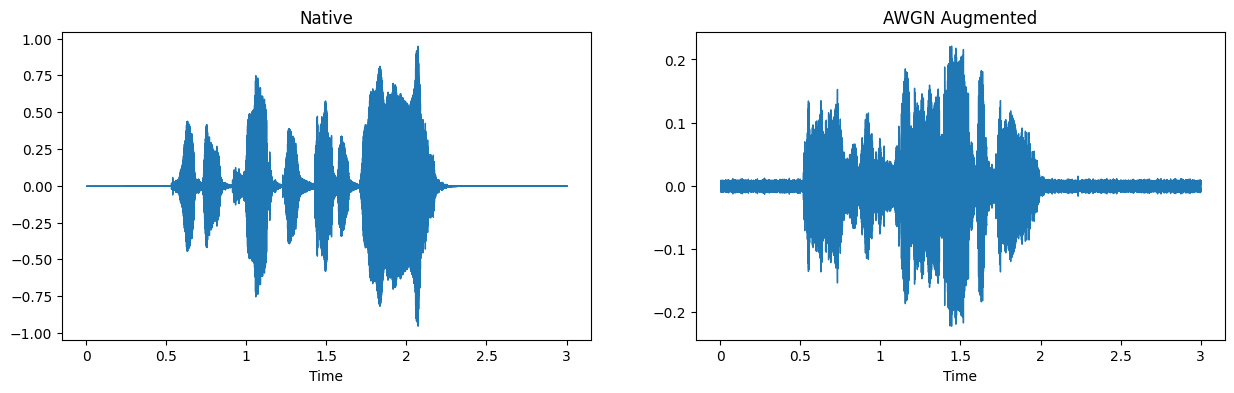

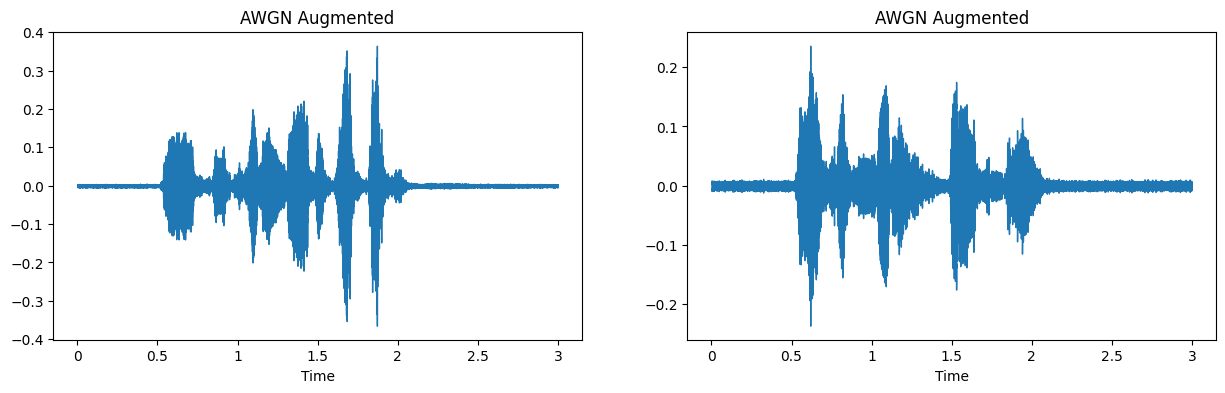

In [14]:
plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
librosa.display.waveshow(waveforms[12], sr=sample_rate)
plt.title('Native')

plt.subplot(1, 2, 2)
# augmented waveforms are 2D len 1440 list with 2 waveforms in each position
librosa.display.waveshow(augmented_waveforms_temp[0][0], sr=sample_rate)
plt.title('AWGN Augmented')
plt.show()

plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
librosa.display.waveshow(augmented_waveforms_temp[2][0], sr=sample_rate)
plt.title('AWGN Augmented')

plt.subplot(1, 2, 2)
librosa.display.waveshow(augmented_waveforms_temp[7][0], sr=sample_rate)
plt.title('AWGN Augmented')
plt.show()

In [15]:
X_train = np.expand_dims(features_train, 1)
X_valid = np.expand_dims(features_valid, 1)
X_test = np.expand_dims(features_test, 1)


y_train = np.array(y_train)
y_valid = np.array(y_valid)
y_test = np.array(y_test)

# confiorm that we have tensor-ready 4D data array
# should print (batch, channel, width, height) == (4320, 1, 128, 282) when multiples==2
print(f'Shape of 4D feature array for input tensor: {X_train.shape} train, {X_valid.shape} validation, {X_test.shape} test')
print(f'Shape of emotion labels: {y_train.shape} train, {y_valid.shape} validation, {y_test.shape} test')

Shape of 4D feature array for input tensor: (3441, 1, 40, 282) train, (429, 1, 40, 282) validation, (450, 1, 40, 282) test
Shape of emotion labels: (3441,) train, (429,) validation, (450,) test


In [16]:

del features_train, features_valid, features_test, waveforms, augmented_waveforms_temp

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

#### Scale the training data ####
# store shape so we can transform it back
N,C,H,W = X_train.shape
# Reshape to 1D because StandardScaler operates on a 1D array
# tell numpy to infer shape of 1D array with '-1' argument
X_train = np.reshape(X_train, (N,-1))
X_train = scaler.fit_transform(X_train)
# Transform back to NxCxHxW 4D tensor format
X_train = np.reshape(X_train, (N,C,H,W))

##### Scale the validation set ####
N,C,H,W = X_valid.shape
X_valid = np.reshape(X_valid, (N,-1))
X_valid = scaler.transform(X_valid)
X_valid = np.reshape(X_valid, (N,C,H,W))

#### Scale the test set ####
N,C,H,W = X_test.shape
X_test = np.reshape(X_test, (N,-1))
X_test = scaler.transform(X_test)
X_test = np.reshape(X_test, (N,C,H,W))

# check shape of each set again
print(f'X_train scaled:{X_train.shape}, y_train:{y_train.shape}')
print(f'X_valid scaled:{X_valid.shape}, y_valid:{y_valid.shape}')
print(f'X_test scaled:{X_test.shape}, y_test:{y_test.shape}')

X_train scaled:(3441, 1, 40, 282), y_train:(3441,)
X_valid scaled:(429, 1, 40, 282), y_valid:(429,)
X_test scaled:(450, 1, 40, 282), y_test:(450,)


In [19]:
filename = 'features+labels.npy'

# open file in write mode and write data
with open(filename, 'wb') as f:
    np.save(f, X_train)
    np.save(f, X_valid)
    np.save(f, X_test)
    np.save(f, y_train)
    np.save(f, y_valid)
    np.save(f, y_test)

print(f'Features and labels saved to {filename}')

Features and labels saved to features+labels.npy


In [20]:
filename = 'features+labels.npy'

# open file in read mode and read data
with open(filename, 'rb') as f:
    X_train = np.load(f)
    X_valid = np.load(f)
    X_test = np.load(f)
    y_train = np.load(f)
    y_valid = np.load(f)
    y_test = np.load(f)

# Check that we've recovered the right data
print(f'X_train:{X_train.shape}, y_train:{y_train.shape}')
print(f'X_valid:{X_valid.shape}, y_valid:{y_valid.shape}')
print(f'X_test:{X_test.shape}, y_test:{y_test.shape}')

X_train:(3441, 1, 40, 282), y_train:(3441,)
X_valid:(429, 1, 40, 282), y_valid:(429,)
X_test:(450, 1, 40, 282), y_test:(450,)


In [21]:
class parallel_all_you_want(nn.Module):
    # Define all layers present in the network
    def __init__(self,num_emotions):
        super().__init__()

        ################ TRANSFORMER BLOCK #############################
        # maxpool the input feature map/tensor to the transformer
        # a rectangular kernel worked better here for the rectangular input spectrogram feature map/tensor
        self.transformer_maxpool = nn.MaxPool2d(kernel_size=[1,4], stride=[1,4])

        # define single transformer encoder layer
        # self-attention + feedforward network from "Attention is All You Need" paper
        # 4 multi-head self-attention layers each with 40-->512--->40 feedforward network
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=40, # input feature (frequency) dim after maxpooling 40*282 -> 40*70 (MFC*time)
            nhead=4, # 4 self-attention layers in each multi-head self-attention layer in each encoder block
            dim_feedforward=512, # 2 linear layers in each encoder block's feedforward network: dim 40-->512--->40
            dropout=0.4,
            activation='relu' # ReLU: avoid saturation/tame gradient/reduce compute time
        )

        # I'm using 4 instead of the 6 identical stacked encoder layrs used in Attention is All You Need paper
        # Complete transformer block contains 4 full transformer encoder layers (each w/ multihead self-attention+feedforward)
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=4)
        self.conv2Dblock1 = nn.Sequential(

            # 1st 2D convolution layer
            nn.Conv2d(
                in_channels=1, # input volume depth == input channel dim == 1
                out_channels=16, # expand output feature map volume's depth to 16
                kernel_size=3, # typical 3*3 stride 1 kernel
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(16), # batch normalize the output feature map before activation
            nn.ReLU(), # feature map --> activation map
            nn.MaxPool2d(kernel_size=2, stride=2), #typical maxpool kernel size
            nn.Dropout(p=0.3), #randomly zero 30% of 1st layer's output feature map in training

            # 2nd 2D convolution layer identical to last except output dim, maxpool kernel
            nn.Conv2d(
                in_channels=16,
                out_channels=32, # expand output feature map volume's depth to 32
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4), # increase maxpool kernel for subsequent filters
            nn.Dropout(p=0.3),
              nn.Conv2d(
                in_channels=32,
                out_channels=64, # expand output feature map volume's depth to 64
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
        )
        ############### 2ND PARALLEL 2D CONVOLUTION BLOCK ############
        # 3 sequential conv2D layers: (1,40,282) --> (16, 20, 141) -> (32, 5, 35) -> (64, 1, 8)
        self.conv2Dblock2 = nn.Sequential(

            # 1st 2D convolution layer
            nn.Conv2d(
                in_channels=1, # input volume depth == input channel dim == 1
                out_channels=16, # expand output feature map volume's depth to 16
                kernel_size=3, # typical 3*3 stride 1 kernel
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(16), # batch normalize the output feature map before activation
            nn.ReLU(), # feature map --> activation map
            nn.MaxPool2d(kernel_size=2, stride=2), #typical maxpool kernel size
            nn.Dropout(p=0.3), #randomly zero 30% of 1st layer's output feature map in training
             nn.Conv2d(
                in_channels=16,
                out_channels=32, # expand output feature map volume's depth to 32
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4), # increase maxpool kernel for subsequent filters
            nn.Dropout(p=0.3),

            # 3rd 2D convolution layer identical to last except output dim
            nn.Conv2d(
                in_channels=32,
                out_channels=64, # expand output feature map volume's depth to 64
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
        )
        self.fc1_linear = nn.Linear(512*2+40,num_emotions)

        ### Softmax layer for the 8 output logits from final FC linear layer
        self.softmax_out = nn.Softmax(dim=1) # dim==1 is the freq embedding
    def forward(self,x):

        ############ 1st parallel Conv2D block: 4 Convolutional layers ############################
        # create final feature embedding from 1st convolutional layer
        # input features pased through 4 sequential 2D convolutional layers
        conv2d_embedding1 = self.conv2Dblock1(x) # x == N/batch * channel * freq * time

        # flatten final 64*1*8 feature map from convolutional layers to length 512 1D array
        # skip the 1st (N/batch) dimension when flattening
        conv2d_embedding1 = torch.flatten(conv2d_embedding1, start_dim=1)

        ############ 2nd parallel Conv2D block: 4 Convolutional layers #############################
        # create final feature embedding from 2nd convolutional layer
        # input features pased through 4 sequential 2D convolutional layers
        conv2d_embedding2 = self.conv2Dblock2(x) # x == N/batch * channel * freq * time

        # flatten final 64*1*8 feature map from convolutional layers to length 512 1D array
        # skip the 1st (N/batch) dimension when flattening
        conv2d_embedding2 = torch.flatten(conv2d_embedding2, start_dim=1)


        ########## 4-encoder-layer Transformer block w/ 40-->512-->40 feedfwd network ##############
        # maxpool input feature map: 1*40*282 w/ 1*4 kernel --> 1*40*70
        x_maxpool = self.transformer_maxpool(x)

        # remove channel dim: 1*40*70 --> 40*70
        x_maxpool_reduced = torch.squeeze(x_maxpool,1)

        # convert maxpooled feature map format: batch * freq * time ---> time * batch * freq format
        # because transformer encoder layer requires tensor in format: time * batch * embedding (freq)
        x = x_maxpool_reduced.permute(2,0,1)

        # finally, pass reduced input feature map x into transformer encoder layers
        transformer_output = self.transformer_encoder(x)

        # create final feature emedding from transformer layer by taking mean in the time dimension (now the 0th dim)
        # transformer outputs 2x40 (MFCC embedding*time) feature map, take mean of columns i.e. take time average
        transformer_embedding = torch.mean(transformer_output, dim=0) # dim 40x70 --> 40
        complete_embedding = torch.cat([conv2d_embedding1, conv2d_embedding2,transformer_embedding], dim=1)

        ######### final FC linear layer, need logits for loss #########################
        output_logits = self.fc1_linear(complete_embedding)

        ######### Final Softmax layer: use logits from FC linear, get softmax for prediction ######
        output_softmax = self.softmax_out(output_logits)

        # need output logits to compute cross entropy loss, need softmax probabilities to predict class
        return output_logits, output_softmax

In [23]:
!pip install torchinfo
from torchinfo import summary

# need device to instantiate model
device = 'cpu'

# instantiate model for 8 emotions and move to GPU
model = parallel_all_you_want(len(emotions_dict)).to(device)

# include input feature map dims in call to summary()
summary(model, input_size=(2,1,40,282))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Layer (type:depth-idx)                        Output Shape              Param #
parallel_all_you_want                         [2, 8]                    --
├─Sequential: 1-1                             [2, 64, 1, 8]             --
│    └─Conv2d: 2-1                            [2, 16, 40, 282]          160
│    └─BatchNorm2d: 2-2                       [2, 16, 40, 282]          32
│    └─ReLU: 2-3                              [2, 16, 40, 282]          --
│    └─MaxPool2d: 2-4                         [2, 16, 20, 141]          --
│    └─Dropout: 2-5                           [2, 16, 20, 141]          --
│    └─Conv2d: 2-6                            [2, 32, 20, 141]          4,640
│    └─BatchNorm2d: 2-7                       [2, 32, 20, 141]          64
│    └─ReLU: 2-8                              [2, 32, 20, 141]          --
│    └─MaxPool2d: 2-9                         [2, 32, 5, 35]            --
│    └─Dropout: 2-10                          [2, 32, 5, 35]            --
│    └─Conv2d: 2

In [24]:
def criterion(predictions, targets):
    return nn.CrossEntropyLoss()(input=predictions, target=targets)

In [25]:
optimizer = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=1e-3, momentum=0.8)

In [26]:
# define function to create a single step of the training phase
def make_train_step(model, criterion, optimizer):

    # define the training step of the training phase
    def train_step(X,Y):

        # forward pass
        output_logits, output_softmax = model(X)
        predictions = torch.argmax(output_softmax,dim=1)
        accuracy = torch.sum(Y==predictions)/float(len(Y))

        # compute loss on logits because nn.CrossEntropyLoss implements log softmax
        loss = criterion(output_logits, Y)

        # compute gradients for the optimizer to use
        loss.backward()

        # update network parameters based on gradient stored (by calling loss.backward())
        optimizer.step()

        # zero out gradients for next pass
        # pytorch accumulates gradients from backwards passes (convenient for RNNs)
        optimizer.zero_grad()

        return loss.item(), accuracy*100
    return train_step

In [27]:
def make_validate_fnc(model,criterion):
    def validate(X,Y):

        # don't want to update any network parameters on validation passes: don't need gradient
        # wrap in torch.no_grad to save memory and compute in validation phase:
        with torch.no_grad():

            # set model to validation phase i.e. turn off dropout and batchnorm layers
            model.eval()

            # get the model's predictions on the validation set
            output_logits, output_softmax = model(X)
            predictions = torch.argmax(output_softmax,dim=1)
            print(predictions.shape, "pred_shape")
            print(Y.shape, "Y_shape")

            # calculate the mean accuracy over the entire validation set
            accuracy = torch.sum(Y==predictions)/float(len(Y))

            # compute error from logits (nn.crossentropy implements softmax)
            loss = criterion(output_logits,Y)

        return loss.item(), accuracy*100, predictions
    return validate

In [28]:
def make_save_checkpoint():
    def save_checkpoint(optimizer, model, epoch, filename):
        checkpoint_dict = {
            'optimizer': optimizer.state_dict(),
            'model': model.state_dict(),
            'epoch': epoch
        }
        torch.save(checkpoint_dict, filename)
    return save_checkpoint

def load_checkpoint(optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    epoch = checkpoint_dict['epoch']
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    return epoch

In [29]:
# get training set size to calculate # iterations and minibatch indices
train_size = X_train.shape[0]

# pick minibatch size (of 32... always)
minibatch = 32

# set device to GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'{device} selected')

# instantiate model and move to GPU for training
model = parallel_all_you_want(num_emotions=len(emotions_dict)).to(device)
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )

# encountered bugs in google colab only, unless I explicitly defined optimizer in this cell...
optimizer = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=1e-3, momentum=0.8)

# instantiate the checkpoint save function
save_checkpoint = make_save_checkpoint()

# instantiate the training step function
train_step = make_train_step(model, criterion, optimizer=optimizer)

# instantiate the validation loop function
validate = make_validate_fnc(model,criterion)

# instantiate lists to hold scalar performance metrics to plot later
train_losses=[]
valid_losses = []

# create training loop for one complete epoch (entire training set)
def train(optimizer, model, num_epochs, X_train, Y_train, X_valid, Y_valid):

    for epoch in range(num_epochs):

        # set model to train phase
        model.train()

        # shuffle entire training set in each epoch to randomize minibatch order
        train_indices = np.random.permutation(train_size)

        # shuffle the training set for each epoch:
        X_train = X_train[train_indices,:,:,:]
        Y_train = Y_train[train_indices]

        # instantiate scalar values to keep track of progress after each epoch so we can stop training when appropriate
        epoch_acc = 0
        epoch_loss = 0
        num_iterations = int(train_size / minibatch)

        # create a loop for each minibatch of 32 samples:
        for i in range(num_iterations):

            # we have to track and update minibatch position for the current minibatch
            # if we take a random batch position from a set, we almost certainly will skip some of the data in that set
            # track minibatch position based on iteration number:
            batch_start = i * minibatch
            # ensure we don't go out of the bounds of our training set:
            batch_end = min(batch_start + minibatch, train_size)
            # ensure we don't have an index error
            actual_batch_size = batch_end-batch_start

            # get training minibatch with all channnels and 2D feature dims
            X = X_train[batch_start:batch_end,:,:,:]
            # get training minibatch labels
            Y = Y_train[batch_start:batch_end]

            # instantiate training tensors
            X_tensor = torch.tensor(X, device=device).float()
            Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)

            # Pass input tensors thru 1 training step (fwd+backwards pass)
            loss, acc = train_step(X_tensor,Y_tensor)

            # aggregate batch accuracy to measure progress of entire epoch
            epoch_acc += acc * actual_batch_size / train_size
            epoch_loss += loss * actual_batch_size / train_size

            # keep track of the iteration to see if the model's too slow
            print('\r'+f'Epoch {epoch+1}: iteration {i}/{num_iterations}',end='')

        # create tensors from validation set
        X_valid_tensor = torch.tensor(X_valid,device=device).float()
        Y_valid_tensor = torch.tensor(Y_valid,dtype=torch.long,device=device)
        print(X_valid_tensor.shape)
        print(Y_valid_tensor.shape)
        # calculate validation metrics to keep track of progress; don't need predictions now
        valid_loss, valid_acc, _ = validate(X_valid_tensor,Y_valid_tensor)

        # accumulate scalar performance metrics at each epoch to track and plot later
        train_losses.append(epoch_loss)
        valid_losses.append(valid_loss)

        # Save checkpoint of the model
        checkpoint_filename = './drive/MyDrive/content/checkpoints/parallel_all_you_wantFINAL-{:03d}.pkl'.format(epoch)
        save_checkpoint(optimizer, model, epoch, checkpoint_filename)

        # keep track of each epoch's progress
        print(f'\nEpoch {epoch+1} --- loss:{epoch_loss:.3f}, Epoch accuracy:{epoch_acc:.2f}%, Validation loss:{valid_loss:.3f}, Validation accuracy:{valid_acc:.2f}%')


cuda selected
Number of trainable params:  248488


In [30]:
# choose number of epochs higher than reasonable so we can manually stop training
num_epochs = 500

# train it!
train(optimizer, model, num_epochs, X_train, y_train, X_valid, y_valid)


Epoch 1: iteration 106/107torch.Size([429, 1, 40, 282])
torch.Size([429])
torch.Size([429]) pred_shape
torch.Size([429]) Y_shape

Epoch 1 --- loss:3.192, Epoch accuracy:24.30%, Validation loss:2.056, Validation accuracy:28.67%
Epoch 2: iteration 106/107torch.Size([429, 1, 40, 282])
torch.Size([429])
torch.Size([429]) pred_shape
torch.Size([429]) Y_shape

Epoch 2 --- loss:1.627, Epoch accuracy:38.65%, Validation loss:1.809, Validation accuracy:33.33%
Epoch 3: iteration 106/107torch.Size([429, 1, 40, 282])
torch.Size([429])
torch.Size([429]) pred_shape
torch.Size([429]) Y_shape

Epoch 3 --- loss:1.502, Epoch accuracy:42.52%, Validation loss:1.646, Validation accuracy:38.00%
Epoch 4: iteration 106/107torch.Size([429, 1, 40, 282])
torch.Size([429])
torch.Size([429]) pred_shape
torch.Size([429]) Y_shape

Epoch 4 --- loss:1.411, Epoch accuracy:46.29%, Validation loss:1.594, Validation accuracy:38.93%
Epoch 5: iteration 106/107torch.Size([429, 1, 40, 282])
torch.Size([429])
torch.Size([429]) 

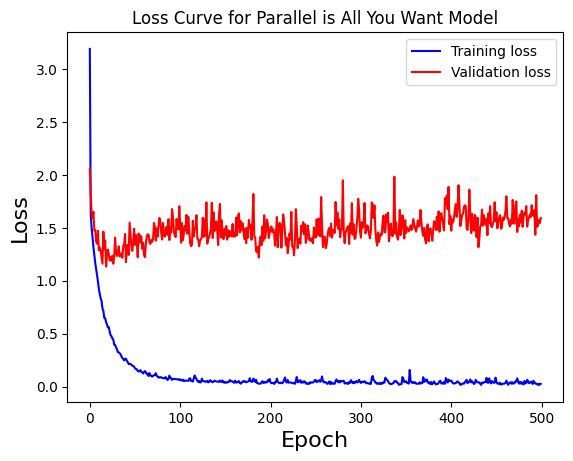

In [31]:
plt.title('Loss Curve for Parallel is All You Want Model')
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.plot(train_losses[:],'b')
plt.plot(valid_losses[:],'r')
plt.legend(['Training loss','Validation loss'])
plt.show()


In [32]:
# pick load folder
load_folder = './drive/MyDrive/content/checkpoints'

# pick the epoch to load
epoch = '429'
model_name = f'parallel_all_you_wantFINAL-{epoch}.pkl'

# make full load path
load_path = os.path.join(load_folder, model_name)

## instantiate empty model and populate with params from binary
model = parallel_all_you_want(len(emotions_dict))
load_checkpoint(optimizer, model, load_path)

print(f'Loaded model from {load_path}')

Loaded model from ./drive/MyDrive/content/checkpoints/parallel_all_you_wantFINAL-429.pkl


In [36]:

validate = make_validate_fnc(model,criterion)
X_test_tensor = torch.tensor(X_test,device=device).float()
y_test_tensor = torch.tensor(y_test,dtype=torch.long,device=device)
test_loss, test_acc, predicted_emotions = validate(X_test_tensor,y_test_tensor)

print(f'Test accuracy is {test_acc:.2f}%')

torch.Size([450]) pred_shape
torch.Size([450]) Y_shape
Test accuracy is 62.44%


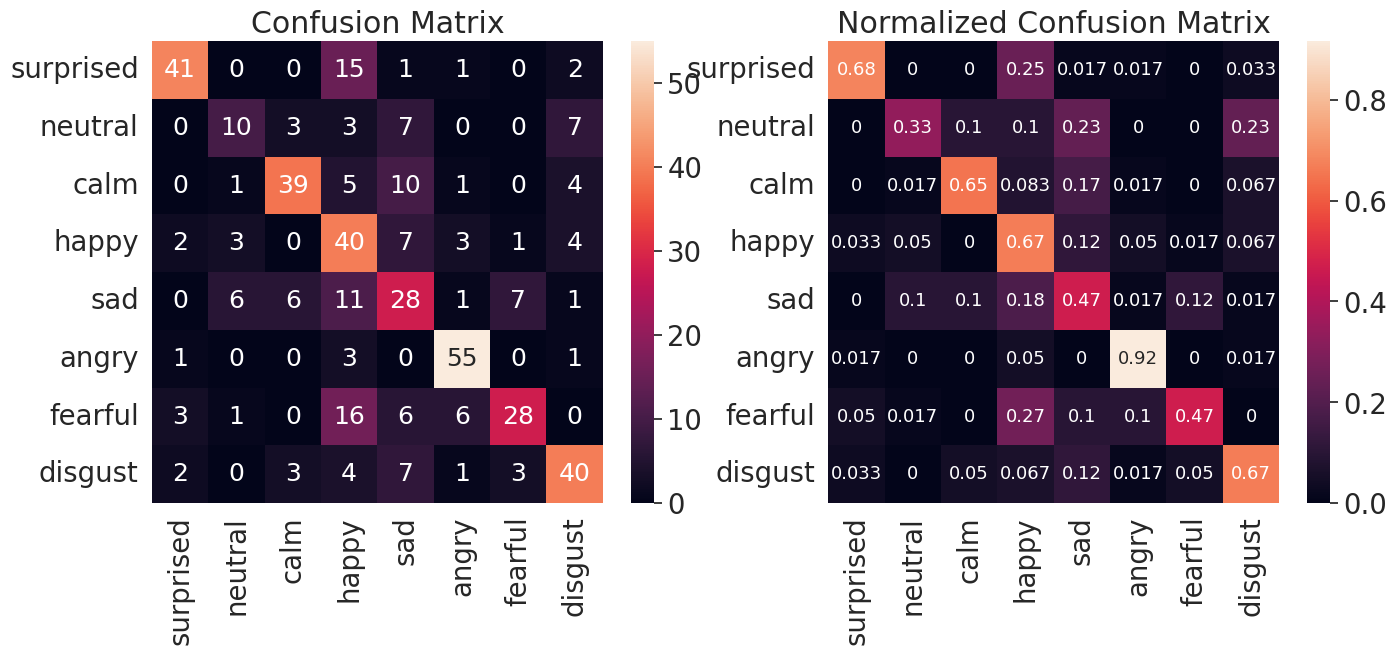

In [37]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, matthews_corrcoef


import seaborn as sn

# because model tested on GPU, move prediction tensor to CPU then convert to array
predicted_emotions = predicted_emotions.cpu().numpy()
# use labels from test set
emotions_groundtruth = y_test

# build confusion matrix and normalized confusion matrix
conf_matrix = confusion_matrix(emotions_groundtruth, predicted_emotions)
conf_matrix_norm = confusion_matrix(emotions_groundtruth, predicted_emotions,normalize='true')

# set labels for matrix axes from emotions
emotion_names = [emotion for emotion in emotions_dict.values()]

# make a confusion matrix with labels using a DataFrame
confmatrix_df = pd.DataFrame(conf_matrix, index=emotion_names, columns=emotion_names)
confmatrix_df_norm = pd.DataFrame(conf_matrix_norm, index=emotion_names, columns=emotion_names)

# plot confusion matrices
plt.figure(figsize=(16,6))
sn.set(font_scale=1.8) # emotion label and title size
plt.subplot(1,2,1)
plt.title('Confusion Matrix')
sn.heatmap(confmatrix_df, annot=True, annot_kws={"size": 18}) #annot_kws is value font
plt.subplot(1,2,2)
plt.title('Normalized Confusion Matrix')
sn.heatmap(confmatrix_df_norm, annot=True, annot_kws={"size": 13}) #annot_kws is value font

plt.show()

In [38]:

f1_micro = f1_score(emotions_groundtruth, predicted_emotions, average='micro')
f1_macro = f1_score(emotions_groundtruth, predicted_emotions, average='macro')
f1_weighted = f1_score(emotions_groundtruth, predicted_emotions, average='weighted')

# Calculate MCC
mcc = matthews_corrcoef(emotions_groundtruth, predicted_emotions)

# Print the F1 score and MCC
print("F1 micro:", f1_micro)
print("F1 macro:", f1_macro)
print("F1 weighted:", f1_weighted)
print("MCC:", mcc)

F1 micro: 0.6244444444444445
F1 macro: 0.6123065251526095
F1 weighted: 0.6269831693131103
MCC: 0.5717953320228776


In [39]:
from sklearn.metrics import precision_score, recall_score
precision_micro = precision_score(emotions_groundtruth, predicted_emotions, average='micro')
precision_macro = precision_score(emotions_groundtruth, predicted_emotions, average='macro')
precision_weighted = precision_score(emotions_groundtruth, predicted_emotions, average='weighted')

# Calculate recall with averaging
recall_micro = recall_score(emotions_groundtruth, predicted_emotions, average='micro')
recall_macro = recall_score(emotions_groundtruth, predicted_emotions, average='macro')
recall_weighted = recall_score(emotions_groundtruth, predicted_emotions, average='weighted')

In [40]:
print("Precision micro:", precision_micro)
print("Precision macro:", precision_macro)
print("Precision weighted:", precision_weighted)
print("Recall micro:", recall_micro)
print("Recall macro:", recall_macro)
print("Recall weighted:", recall_weighted)

Precision micro: 0.6244444444444445
Precision macro: 0.6398728699674261
Precision weighted: 0.6507850295525562
Recall micro: 0.6244444444444445
Recall macro: 0.60625
Recall weighted: 0.6244444444444445


In [44]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, matthews_corrcoef



# Calculate F1 score with averaging
f1_micro = f1_score(emotions_groundtruth, predicted_emotions, average='micro')
f1_macro = f1_score(emotions_groundtruth, predicted_emotions, average='macro')
f1_weighted = f1_score(emotions_groundtruth, predicted_emotions, average='weighted')

# Calculate MCC
mcc = matthews_corrcoef(emotions_groundtruth, predicted_emotions)

# Print the F1 score and MCCemotions
print("F1 micro:", f1_micro)
print("F1 macro:", f1_macro)
print("F1 weighted:", f1_weighted)
print("MCC:",mcc)
# Calculate precision with averaging
precision_micro = precision_score(emotions_groundtruth, predicted_emotions, average='micro')
precision_macro = precision_score(emotions_groundtruth, predicted_emotions, average='macro')
precision_weighted = precision_score(emotions_groundtruth, predicted_emotions, average='weighted')

# Calculate recall with averaging
recall_micro = recall_score(emotions_groundtruth, predicted_emotions, average='micro')
recall_macro = recall_score(emotions_groundtruth, predicted_emotions, average='macro')
recall_weighted = recall_score(emotions_groundtruth, predicted_emotions, average='weighted')

# Print precision and recall
print("Precision micro:", precision_micro)
print("Precision macro:", precision_macro)
print("Precision weighted:", precision_weighted)
print("Recall micro:", recall_micro)
print("Recall macro:", recall_macro)
print("Recall weighted:", recall_weighted)

F1 micro: 0.6244444444444445
F1 macro: 0.6123065251526095
F1 weighted: 0.6269831693131103
MCC: 0.5717953320228776
Precision micro: 0.6244444444444445
Precision macro: 0.6398728699674261
Precision weighted: 0.6507850295525562
Recall micro: 0.6244444444444445
Recall macro: 0.60625
Recall weighted: 0.6244444444444445


In [45]:
import numpy as np

# Convert the DataFrame to a NumPy array
confusion_matrix = confmatrix_df_norm.to_numpy()

# Calculate True Positives, False Positives, False Negatives from the confusion matrix
true_positives = np.diag(confusion_matrix)
false_positives = np.sum(confusion_matrix, axis=0) - true_positives
false_negatives = np.sum(confusion_matrix, axis=1) - true_positives

# Calculate Precision, Recall, F1 Score
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1_score = 2 * (precision * recall) / (precision + recall)

# Calculate True Negatives from the confusion matrix
true_negatives = np.sum(confusion_matrix) - (true_positives + false_positives + false_negatives)

# Calculate Matthews Correlation Coefficient (MCC)
mcc = (true_positives * true_negatives - false_positives * false_negatives) / np.sqrt((true_positives + false_positives) * (true_positives + false_negatives) * (true_negatives + false_positives) * (true_negatives + false_negatives))

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print("MCC:", mcc)


Precision: [0.83673469 0.64516129 0.72222222 0.4        0.38356164 0.80882353
 0.71794872 0.60606061]
Recall: [0.68333333 0.33333333 0.65       0.66666667 0.46666667 0.91666667
 0.46666667 0.66666667]
F1 Score: [0.75229358 0.43956044 0.68421053 0.5        0.42105263 0.859375
 0.56565657 0.63492063]
MCC: [0.72563548 0.41327266 0.64293787 0.4265617  0.33110771 0.84002238
 0.53317664 0.58078121]
